In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
%matplotlib inline

In [ ]:
# Load the dataset (assuming it's in a file named 'telecom_churn.csv')
df = pd.read_csv('/content/telecom_churn_data.csv')

In [ ]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)


Dataset Shape: (2000, 21)


In [ ]:
print("\nColumn Names:")
print(df.columns.tolist())


Column Names:
['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
print("\nData Types:")
print(df.dtypes)


Data Types:
CustomerID           object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [ ]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
CustomerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        20
Churn                0
dtype: int64


In [ ]:
# Display summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(df[['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']].describe())


Summary Statistics for Numerical Features:
       SeniorCitizen       Tenure  MonthlyCharges  TotalCharges
count    2000.000000  2000.000000     2000.000000   1980.000000
mean        0.154500    35.747500       65.224985   2348.392167
std         0.361518    20.753797       27.573737   1759.583560
min         0.000000     1.000000       18.000000     25.230000
25%         0.000000    18.000000       44.772500    928.400000
50%         0.000000    35.000000       65.155000   1931.245000
75%         0.000000    54.000000       85.605000   3469.537500
max         1.000000    72.000000      120.000000   8767.110000


In [ ]:
# Create a copy of the dataframe for processing
df_clean = df.copy()

In [ ]:
# Handle missing values in TotalCharges
print("Number of missing values in TotalCharges:", df_clean['TotalCharges'].isnull().sum())

Number of missing values in TotalCharges: 20


In [ ]:
# Since only 20 records have missing TotalCharges, let's examine them
missing_total_charges = df_clean[df_clean['TotalCharges'].isnull()]
print("\nTenure values for records with missing TotalCharges:")
print(missing_total_charges['Tenure'].value_counts())


Tenure values for records with missing TotalCharges:
Tenure
2    12
1     8
Name: count, dtype: int64


In [ ]:
# For missing TotalCharges, we can impute with Tenure * MonthlyCharges
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean.loc[df_clean['TotalCharges'].isnull(), 'TotalCharges'] = \
    df_clean[df_clean['TotalCharges'].isnull()]['Tenure'] * \
    df_clean[df_clean['TotalCharges'].isnull()]['MonthlyCharges']

In [ ]:
# Convert SeniorCitizen to categorical for better analysis
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

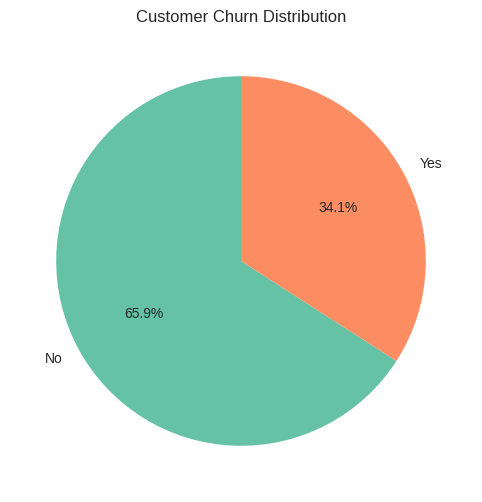

Churn Rate: 34.10%


In [ ]:
# Check the target variable distribution
plt.figure(figsize=(8, 6))
churn_counts = df_clean['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.show()

print("Churn Rate: {:.2f}%".format(churn_counts['Yes']/len(df_clean)*100))


#Exploratory Data Analysis (EDA)

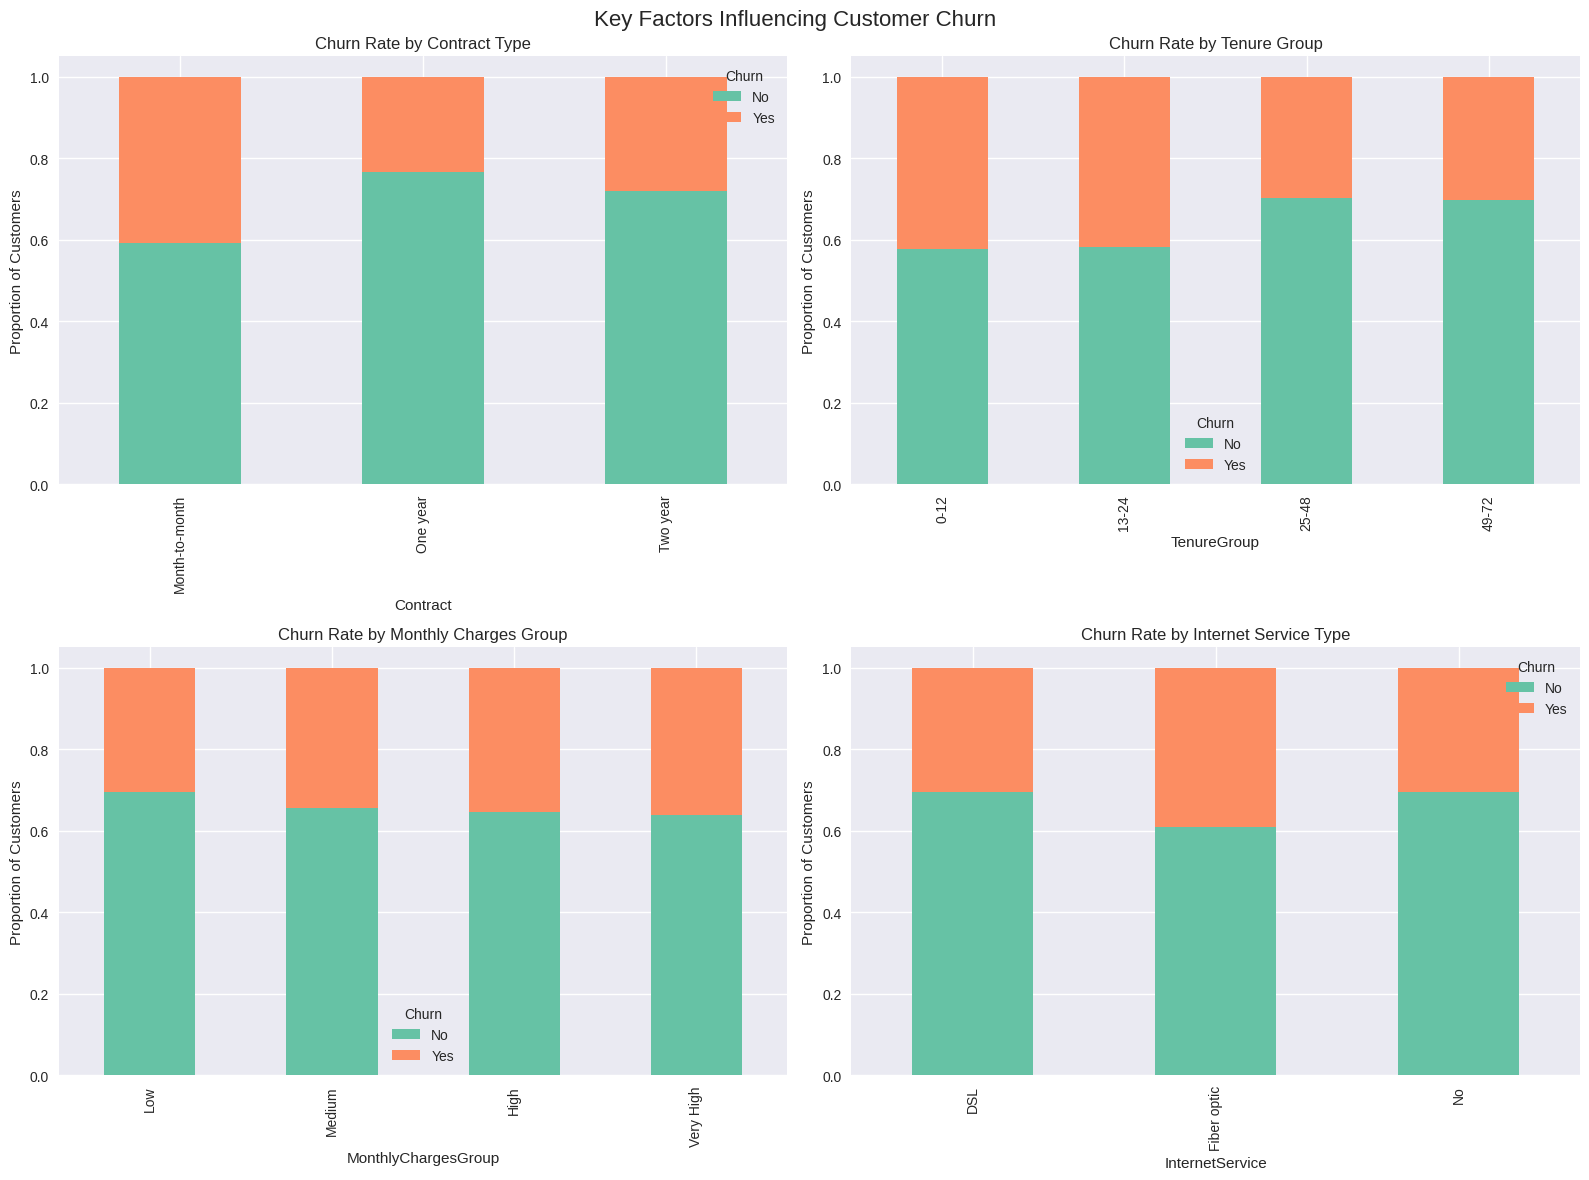

In [ ]:
# Set up the visualization framework
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Factors Influencing Customer Churn', fontsize=16)

# 1. Churn by Contract Type
contract_churn = pd.crosstab(df_clean['Contract'], df_clean['Churn'])
contract_churn.div(contract_churn.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, ax=axes[0,0])
axes[0,0].set_title('Churn Rate by Contract Type')
axes[0,0].set_ylabel('Proportion of Customers')

# 2. Churn by Tenure Groups
df_clean['TenureGroup'] = pd.cut(df_clean['Tenure'], bins=[0, 12, 24, 48, 72],
                                labels=['0-12', '13-24', '25-48', '49-72'])
tenure_churn = pd.crosstab(df_clean['TenureGroup'], df_clean['Churn'])
tenure_churn.div(tenure_churn.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Churn Rate by Tenure Group')
axes[0,1].set_ylabel('Proportion of Customers')

# 3. Churn by Monthly Charges Quartiles
df_clean['MonthlyChargesGroup'] = pd.qcut(df_clean['MonthlyCharges'], q=4,
                                         labels=['Low', 'Medium', 'High', 'Very High'])
monthly_churn = pd.crosstab(df_clean['MonthlyChargesGroup'], df_clean['Churn'])
monthly_churn.div(monthly_churn.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Churn Rate by Monthly Charges Group')
axes[1,0].set_ylabel('Proportion of Customers')

# 4. Churn by Internet Service Type
internet_churn = pd.crosstab(df_clean['InternetService'], df_clean['Churn'])
internet_churn.div(internet_churn.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Internet Service Type')
axes[1,1].set_ylabel('Proportion of Customers')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

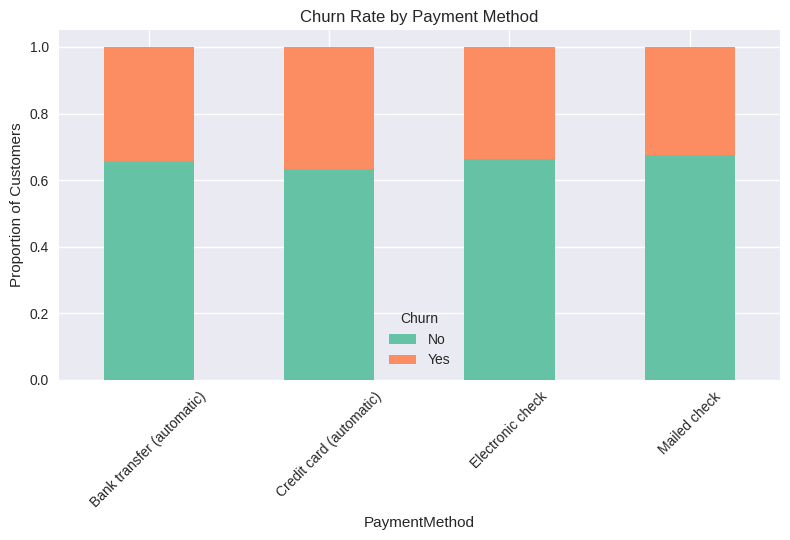

In [ ]:
# Additional EDA - Payment Method impact
plt.figure(figsize=(12, 6))
payment_churn = pd.crosstab(df_clean['PaymentMethod'], df_clean['Churn'])
payment_churn.div(payment_churn.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Churn Rate by Payment Method')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

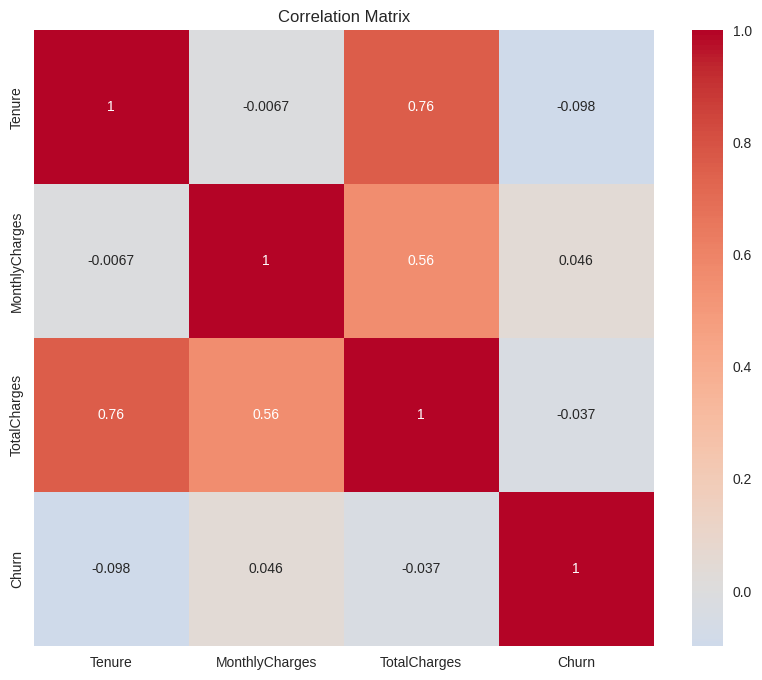

In [ ]:
# Correlation analysis
numeric_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(10, 8))
corr_matrix = df_clean[numeric_features + ['Churn']].apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#Feature Engineering

In [ ]:
# Prepare data for modeling
df_model = df_clean.copy()

In [ ]:
# Define categorical and numerical features
categorical_features = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
# Encode the target variable
df_model['Churn'] = df_model['Churn'].map({'No': 0, 'Yes': 1})

In [ ]:
# Create dummy variables for categorical features
df_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True)

In [ ]:
# Check the shape after encoding
print("Dataset shape after encoding:", df_encoded.shape)

Dataset shape after encoding: (2000, 34)


In [ ]:
# Define features and target
X = df_encoded.drop(['Churn', 'CustomerID', 'TenureGroup', 'MonthlyChargesGroup'], axis=1)
y = df_encoded['Churn']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (1600, 30)
Testing set shape: (400, 30)


#Handling Class Imbalance

In [ ]:
X_train_balanced = X_train_scaled # Just for consistent variable naming
y_train_balanced = y_train        # Just for consistent variable naming

print("\nUsing original distribution with class weights:")
print(y_train_balanced.value_counts())


Using original distribution with class weights:
Churn
0    1054
1     546
Name: count, dtype: int64


#Model Building and Training

In [ ]:
# Initialize model WITH class_weight
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced') # <-- Keep class_weight
logreg.fit(X_train_balanced, y_train_balanced) # <-- Train on the original imbalanced data

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Evaluate the model
print("Model Evaluation:")
print(classification_report(y_test, y_pred))

Model Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       264
           1       0.43      0.53      0.48       136

    accuracy                           0.60       400
   macro avg       0.58      0.59      0.58       400
weighted avg       0.63      0.60      0.61       400



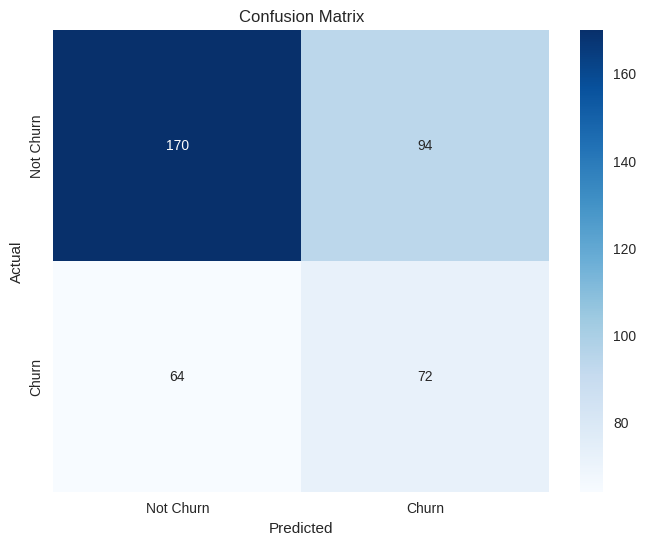

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

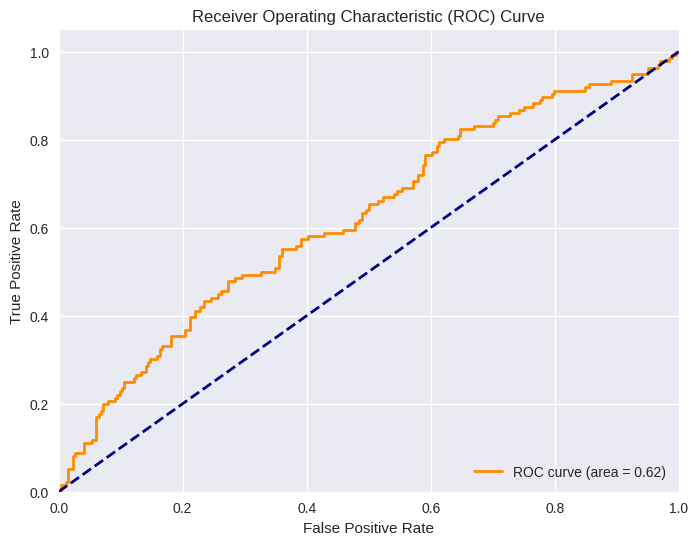

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Feature Importance Analysis

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_balanced.columns,
    'importance': logreg.coef_[0]
})
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

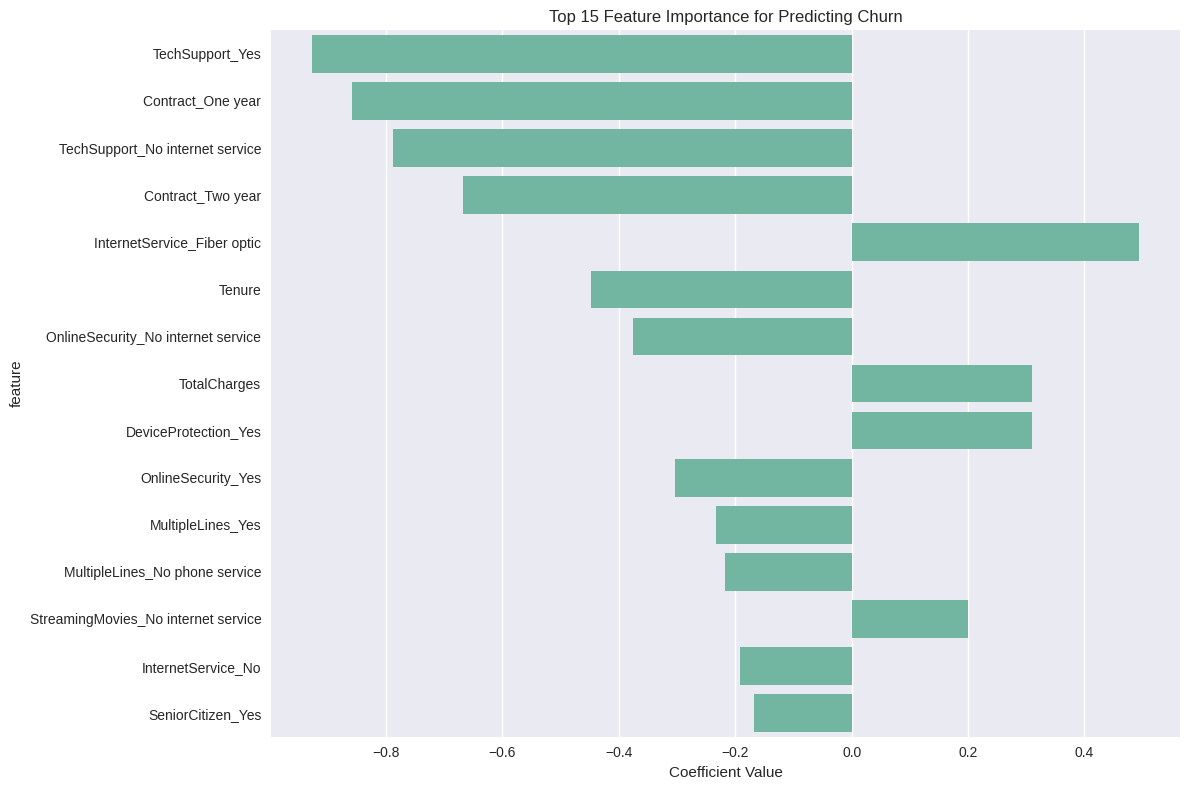

In [ ]:

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Feature Importance for Predicting Churn')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [ ]:
# Display top features with their coefficients
print("Top features influencing churn:")
for idx, row in top_features.iterrows():
    effect = "increases" if row['importance'] > 0 else "decreases"
    print(f"{row['feature']}: {effect} churn likelihood (coefficient: {row['importance']:.4f})")

Top features influencing churn:
TechSupport_Yes: decreases churn likelihood (coefficient: -0.9264)
Contract_One year: decreases churn likelihood (coefficient: -0.8580)
TechSupport_No internet service: decreases churn likelihood (coefficient: -0.7881)
Contract_Two year: decreases churn likelihood (coefficient: -0.6675)
InternetService_Fiber optic: increases churn likelihood (coefficient: 0.4931)
Tenure: decreases churn likelihood (coefficient: -0.4477)
OnlineSecurity_No internet service: decreases churn likelihood (coefficient: -0.3752)
TotalCharges: increases churn likelihood (coefficient: 0.3100)
DeviceProtection_Yes: increases churn likelihood (coefficient: 0.3094)
OnlineSecurity_Yes: decreases churn likelihood (coefficient: -0.3038)
MultipleLines_Yes: decreases churn likelihood (coefficient: -0.2334)
MultipleLines_No phone service: decreases churn likelihood (coefficient: -0.2173)
StreamingMovies_No internet service: increases churn likelihood (coefficient: 0.2006)
InternetService_N

In [ ]:
# Save the final model for future use
import joblib
model_data = {
    'model': logreg,
    'scaler': scaler,
    'features': X_train_balanced.columns.tolist()
}
joblib.dump(model_data, 'telecom_churn_predictor.pkl')
print("Model saved successfully!")

Model saved successfully!
